# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 10*K)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.1

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.05 + 1.15 * (year/45), 0.75)
    else:
        p = min(0.05 + 1.5 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return 0.03 / 2
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0005 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year >= 2040:
        return 0.005 / peace
    else:
        if year < 2025:
            p_invade_taiwan = 0.1 / 5
        elif year < 2030:
            p_invade_taiwan = (0.3 / 5) * (1 - 0.1)
        elif year < 2040:
            p_invade_taiwan = (0.7 / 10) * (1 - 0.3) * (1 - 0.1)
        p_us_responds = 0.6
        return (p_invade_taiwan * p_us_responds) / peace

    
def p_great_power_war_other(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
## AI TIMELINE VARIABLES

def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP'.format(round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = sq.sample(params)
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and sq.event_occurs(p=0.1) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and sq.event_occurs(p=0.6) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 and sq.event_occurs(p=0.8) else f
    return f


def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, sq.const(0)],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)


def max_gdp_frac(war):
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if (not war and r_ < 0.3) or (war and r_ < 0.05):
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif (not war and r_ < 0.9) or (war and r_ < 0.4):
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif not war or (war and r_ < 0.9):
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)
        
    return sq.sample(gdp_frac) * sq.sample(percent_spent_on_compute)


initial_gdp = 21.3*T

initial_flops_per_dollar = sq.const(18)

tai_flop_size = wildeford_meta_anchor

flops_halving_rate = sq.lognorm(2, 5)

initial_pay = sq.mixture([[0.8, sq.const(7.1)],
                          [0.2, sq.lognorm(7.1,9, lclip=7.1)]])

max_flops_per_dollar = sq.const(24)

gdp_growth = sq.lognorm(1.015, 1.035) #NEW

spend_doubling_time = sq.mixture([[0.8, sq.lognorm(3,6)],
                                  [0.2, sq.lognorm(1,2, lclip=1)]])
# TODO: Willingness to spend connected to commercialization

initial_chance_of_nonscaling_issue = 0.95
final_chance_of_nonscaling_issue = 0.3 #NEW
nonscaling_issue_bottom_year = 2050
nonscaling_delay = sq.mixture([[0.7, sq.lognorm(2,10)],
                               [0.3, sq.lognorm(5,40)]]) #NEW

algo_doubling_rate_max = sq.norm(1,3) # NEW
algo_doubling_rate_min = sq.norm(1,2) # NEW

efficiency = sq.mixture([[0.1, sq.const(0)],
                          [0.9, sq.lognorm(1,4)]])

use_efficiency_based_algo_reduction = True
efficiency_based_additional_reduction = sq.mixture([[0.4, sq.const(0)],
                                                    [0.6, sq.norm(0,2)]]) # NEW

p_willingness_ramp = 0

willingness_spend_horizon = sq.const(1)

tai_china_war_delay_yrs = sq.norm(2,6)
tai_china_war_delay_end_year = 2040

tai_catastrophe_delay_yrs = sq.lognorm(4,20)

# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 650:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 650:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 650:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)


print('Loaded')


Loaded


### Overall module structure

In [11]:
exec(open('modules/define_event.py').read())
print('Model loaded')


Model loaded


Anchor debug:
-- 31.4 = 15.8 + 1.1 + -0.9 + 0.7 + 12 - 0.656 * 11.2 + 0.656 * (15.8 + 1.1 - 1.6)
-- 31.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 31.4 log FLOPs (~28 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 6.3x per year to a max of 0.00329% of GDP. GDP grows at a rate of 1.028x per year.
If a non-scaling delay happens, it will take an additional 4.0 years to produce TAI due to issues unrelated to scaling FLOP
-
- Year is 2022 (normal relative year is 0, adjusted relative year is 0)
 --- 25.1 max log FLOP (13 septillion) available - TAI takes 31.4 log FLOP (28 nonillion) - log $ 13.4 to buy TAI (28 trillion) vs. willingness to pay log $ 7.1 (13 mill

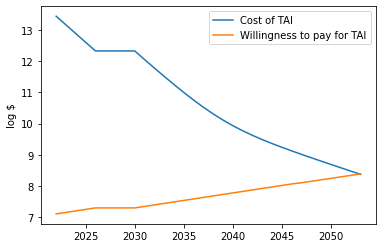

* alignment diagnostic - war: False year: 32 first attempt: False -> p 0.85)
2054: ...XRISK from subtly unaligned TAI :(
-
-
{'collectors': {2022: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'tai': False,
                       'tai_type': None,
                       'tai_year': None,
                       'terminate': False,
                       'war': False,
                       'war_belligerents': None,
                       'war_end_year': No

In [12]:
pprint(define_event(verbose=2))

In [13]:
sq.get_percentiles(sq.sample(lambda: max_gdp_frac(war=True), n=1000))

{1: 6.142262863525986e-06,
 5: 8.650638232309888e-05,
 10: 0.0005270501010151391,
 20: 0.0006357936837823861,
 30: 0.0007650209277108271,
 40: 0.0009366011404876661,
 50: 0.0015904485618858694,
 60: 0.002101982472158728,
 70: 0.0026812987922128144,
 80: 0.0033277250721369667,
 90: 0.005307293851209702,
 95: 0.007806214841614317,
 99: 0.01236991705313403}

In [14]:
sq.get_percentiles(sq.sample(lambda: max_gdp_frac(war=False), n=1000))

{1: 9.392430671683999e-07,
 5: 3.8890572444122984e-06,
 10: 6.774218560630267e-06,
 20: 2.7249890006993013e-05,
 30: 0.0004650536011489975,
 40: 0.000564650974835701,
 50: 0.0006346077074307349,
 60: 0.0006975184846431248,
 70: 0.0007746423765945009,
 80: 0.0008726246857822929,
 90: 0.0012761740384679874,
 95: 0.002278822684545128,
 99: 0.004283284436049057}

In [15]:
sq.get_percentiles(sq.sample(lambda: int(round(sq.sample(tai_china_war_delay_yrs))), n=1000))

{1: 1.0,
 5: 2.0,
 10: 3.0,
 20: 3.0,
 30: 3.0,
 40: 4.0,
 50: 4.0,
 60: 4.0,
 70: 5.0,
 80: 5.0,
 90: 5.100000000000023,
 95: 6.0,
 99: 7.0}

In [16]:
sq.get_percentiles(sq.sample(lambda: int(round(sq.sample(tai_catastrophe_delay_yrs))), n=1000))

{1: 3.0,
 5: 4.0,
 10: 5.0,
 20: 6.0,
 30: 7.0,
 40: 8.0,
 50: 9.0,
 60: 10.0,
 70: 12.0,
 80: 13.0,
 90: 17.0,
 95: 20.0,
 99: 28.0}

-
-
############
## RUN 1 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.0 log FLOP
-- Add 4.1 log FLOP for efficiency
-- Assume a transformative model takes 1.3 log FLOP compared to human
-- Assume a horizon length of 6.5
-- Assume a scaling exponent of 0.6
-- Assume FLOPs per param per sec of 1.4
-- 39.5 = 13.0 + 4.1 + 1.3 + 6.5 + 12 - 0.6 * 11.2 + 0.6 * (13.0 + 4.1 - 1.4)
-- 39.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 39.5 log FLOPs (~3 million decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.9x per year to a max of 0.0% of GDP. GDP grows at a rate of 1.029x per year.
If a non-scaling delay happens, it will take an addition

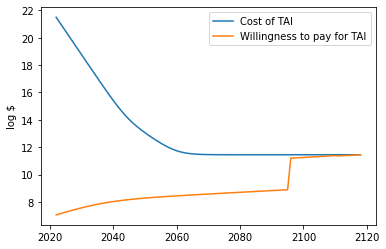

2119: ...XRISK from fully unaligned TAI (singleton) :(
-
-
-
-
############
## RUN 2 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.2 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0.8
-- Assume a scaling exponent of 0.601
-- Assume FLOPs per param per sec of 1.4
-- 30.1 = 14.2 + 1.5 + -0.2 + 0.8 + 12 - 0.601 * 11.2 + 0.601 * (14.2 + 1.5 - 1.4)
-- 30.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.1 log FLOPs (~1 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.7 log 2022$USD (~45 million) and this increases by 4.3x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.02x per y

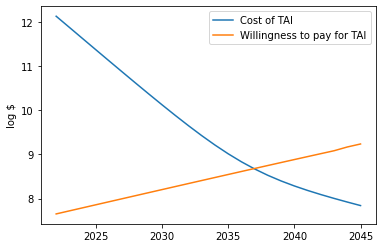

2046: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 3 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.8 log FLOP
-- Add 4.2 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.115
-- Assume FLOPs per param per sec of 1.5
-- 37.8 = 14.8 + 4.2 + -0.0 + 0 + 12 - 1.115 * 11.2 + 1.115 * (14.8 + 4.2 - 1.5)
-- 37.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 37.8 log FLOPs (~70 thousand decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 5.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 3e-05% of GDP. GDP

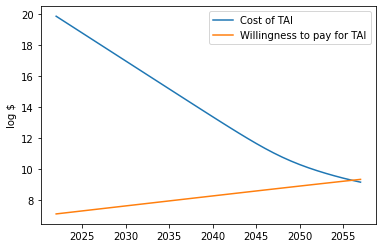

2058: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 4 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.5 log FLOP
-- Add 5.2 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 1.6
-- Assume a scaling exponent of 1.253
-- Assume FLOPs per param per sec of 1.3
-- 37.4 = 12.5 + 5.2 + -0.5 + 1.6 + 12 - 1.253 * 11.2 + 1.253 * (12.5 + 5.2 - 1.3)
-- 37.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 37.4 log FLOPs (~27 thousand decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 5.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.5 log 2022$USD (~31 million) and this increases by 1.4x per year to a max of 0.00085% of GD

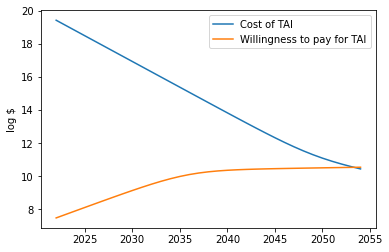

2055: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 5 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.4 log FLOP
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.788
-- Assume FLOPs per param per sec of 1.8
-- 31.1 = 14.4 + 2.1 + -0.1 + 0 + 12 - 0.788 * 11.2 + 0.788 * (14.4 + 2.1 - 1.8)
-- 31.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 31.1 log FLOPs (~14 nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.8x per year to a max of 0.00053% of GDP. GDP grows 

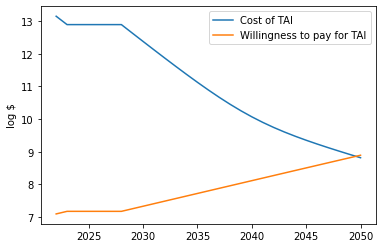

2051: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 6 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.3 log FLOP
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.628
-- Assume FLOPs per param per sec of 1.5
-- 34.4 = 18.3 + 1.0 + -1.0 + 0 + 12 - 0.628 * 11.2 + 0.628 * (18.3 + 1.0 - 1.5)
-- 34.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.4 log FLOPs (~25 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.3 log 2022$USD (~189 million) and this increases by 1.5x per year to a max of 2e-05% of GDP. GDP grows a

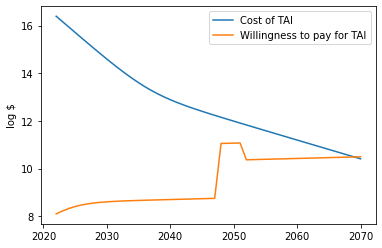

2071: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 7 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.2 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes 0.6 log FLOP compared to human
-- Assume a horizon length of 1.1
-- Assume a scaling exponent of 0.35
-- Assume FLOPs per param per sec of 1.4
-- 31.8 = 15.2 + 1.5 + 0.6 + 1.1 + 12 - 0.35 * 11.2 + 0.35 * (15.2 + 1.5 - 1.4)
-- 31.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 31.8 log FLOPs (~70 nonillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.1x per year to a max of 0.00085% of GDP. GDP grows a

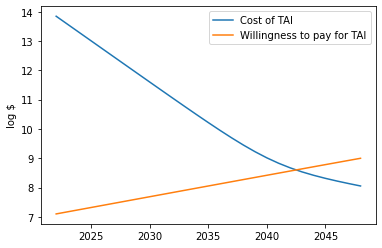

2049: ...Achieved aligned TAI (aligned by default), happy future! :D
-
-
-
-
############
## RUN 8 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.4 log FLOP
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes 0.7 log FLOP compared to human
-- Assume a horizon length of 4.6
-- Assume a scaling exponent of 0.888
-- Assume FLOPs per param per sec of 1.2
-- 47.6 = 19.4 + 2.5 + 0.7 + 4.6 + 12 - 0.888 * 11.2 + 0.888 * (19.4 + 2.5 - 1.2)
-- 47.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 47.6 log FLOPs (~361 trillion decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.5x per year to a max of 0.00108% of GDP. GDP grows 

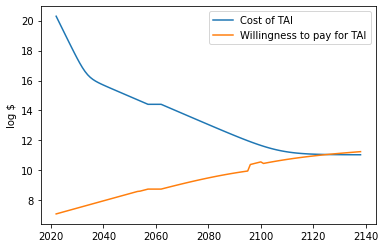

2139: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 10 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.2 log FLOP
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes -2.3 log FLOP compared to human
-- Assume a horizon length of 8.8
-- Assume a scaling exponent of 0.745
-- Assume FLOPs per param per sec of 1.8
-- 36.5 = 13.2 + 2.6 + -2.3 + 8.8 + 12 - 0.745 * 11.2 + 0.745 * (13.2 + 2.6 - 1.8)
-- 36.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 36.5 log FLOPs (~3 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 6.9x per year to a max of 1e-05% of GDP.

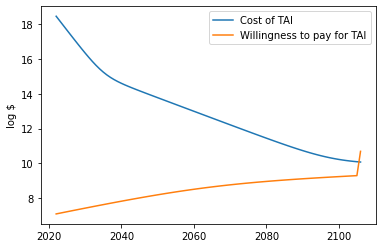

2107: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 11 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.0 log FLOP
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 9.4
-- Assume a scaling exponent of 0.629
-- Assume FLOPs per param per sec of 1.5
-- 43.3 = 17.0 + 1.3 + 0.1 + 9.4 + 12 - 0.629 * 11.2 + 0.629 * (17.0 + 1.3 - 1.5)
-- 43.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 43.3 log FLOPs (~21 billion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.1x per year to a max of 0.00072% of GDP.

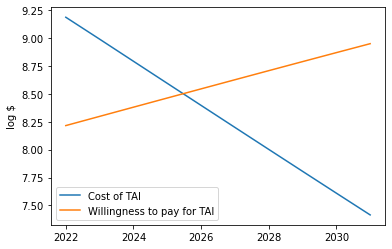

2032: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 15 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.4 log FLOP
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes 0.5 log FLOP compared to human
-- Assume a horizon length of 4.6
-- Assume a scaling exponent of 1.664
-- Assume FLOPs per param per sec of 1.9
-- 42.8 = 15.4 + 2.5 + 0.5 + 4.6 + 12 - 1.664 * 11.2 + 1.664 * (15.4 + 2.5 - 1.9)
-- 42.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 42.8 log FLOPs (~6 billion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.3x per year to a max of 0.00053% of GDP. 

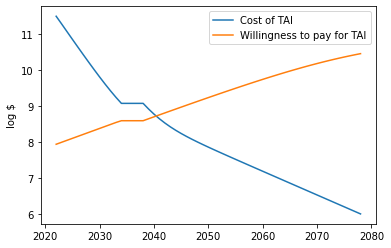

2079: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 17 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.7 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.067
-- Assume FLOPs per param per sec of 1.8
-- 30.9 = 15.7 + 0 + 0.2 + 0 + 12 - 1.067 * 11.2 + 1.067 * (15.7 + 0 - 1.8)
-- 30.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.9 log FLOPs (~8 nonillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.4x per year to a max of 0.00095% of GDP. GDP grows at a rate 

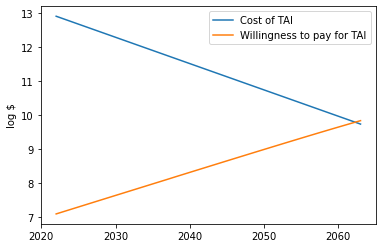

2064: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 18 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.2 log FLOP
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes 0.9 log FLOP compared to human
-- Assume a horizon length of 4.6
-- Assume a scaling exponent of 0.671
-- Assume FLOPs per param per sec of 1.3
-- 40.7 = 17.2 + 1.8 + 0.9 + 4.6 + 12 - 0.671 * 11.2 + 0.671 * (17.2 + 1.8 - 1.3)
-- 40.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.7 log FLOPs (~53 million decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of 0.0% of GDP. GDP grows at a rate of 1.015x per year.


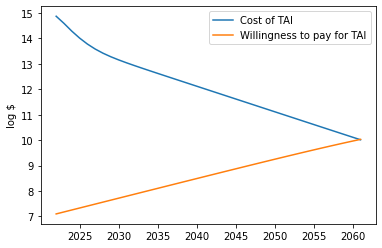

2062: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 21 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.2 log FLOP
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.954
-- Assume FLOPs per param per sec of 1.5
-- 28.0 = 12.2 + 2.2 + -0.0 + 0 + 12 - 0.954 * 11.2 + 0.954 * (12.2 + 2.2 - 1.5)
-- 28.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.0 log FLOPs (~9 octillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.6 log 2022$USD (~393 million) and this increases by 4.1x per year to a max of 0.00045% of GDP. GDP grows

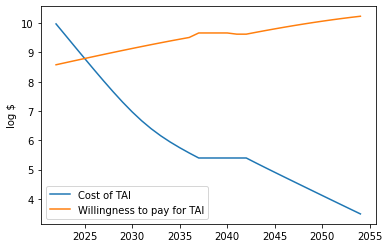

2055: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 22 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.8 log FLOP
-- Add 0.9 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 1.5
-- Assume a scaling exponent of 1.065
-- Assume FLOPs per param per sec of 1.5
-- 27.6 = 12.8 + 0.9 + -0.5 + 1.5 + 12 - 1.065 * 11.2 + 1.065 * (12.8 + 0.9 - 1.5)
-- 27.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 27.6 log FLOPs (~4 octillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 6.1x per year to a max of 6e-05% of GDP. GDP grow

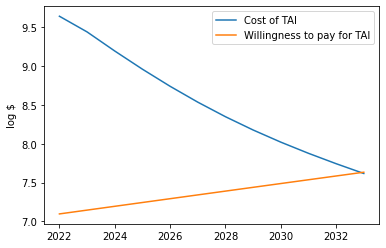

2034: ...Tool TAI made
2142: WAR!!! (Other)
2184: ...catastrophe from nukes (war)
2199: ...catastrophe from nukes (war)
2203: War ends :)
...Boring future
-
-
-
-
############
## RUN 23 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.1 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0.9
-- Assume a scaling exponent of 0.926
-- Assume FLOPs per param per sec of 1.3
-- 40.0 = 19.1 + 1.5 + -0.9 + 0.9 + 12 - 0.926 * 11.2 + 0.926 * (19.1 + 1.5 - 1.3)
-- 40.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.0 log FLOPs (~11 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~

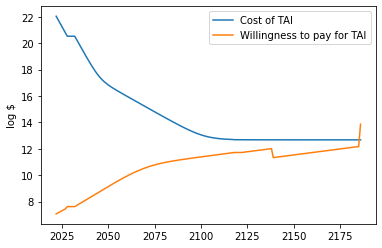

2187: ...XRISK from intentional misuse of TAI (singleton) :(
-
-
-
-
############
## RUN 24 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.2 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.496
-- Assume FLOPs per param per sec of 1.4
-- 28.3 = 14.2 + 0 + -0.2 + 0 + 12 - 1.496 * 11.2 + 1.496 * (14.2 + 0 - 1.4)
-- 28.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.3 log FLOPs (~22 octillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 0.00047% of GDP. GDP grows at a rate of 1.021x per y

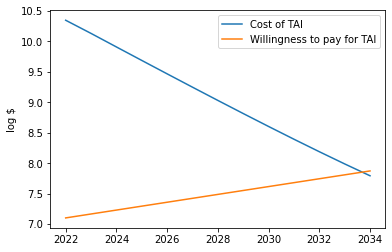

2035: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 25 ##
############
Anchor debug:
-- Assume human brain in inference takes 10.9 log FLOP
-- Add 2.8 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.475
-- Assume FLOPs per param per sec of 1.5
-- 26.7 = 10.9 + 2.8 + -0.5 + 0 + 12 - 1.475 * 11.2 + 1.475 * (10.9 + 2.8 - 1.5)
-- 26.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 26.7 log FLOPs (~544 septillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.9 log 2022$USD (~728 million) and this increases by 4.9x per year to a max of 0.00217% of GDP. GDP gr

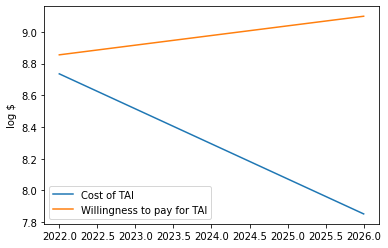

2027: ...Misaligned TAI happened, it was averted with catastrophe, and we abandon TAI
2047: WAR!!! (Other)
2052: War ends :)
2092: ...catastrophe from natural pathogen
2212: WAR!!! (Other)
2213: War ends :)
...Boring future
-
-
-
-
############
## RUN 26 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.8 log FLOP
-- Add 3.3 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.604
-- Assume FLOPs per param per sec of 1.4
-- 29.6 = 12.8 + 3.3 + -0.5 + 0 + 12 - 0.604 * 11.2 + 0.604 * (12.8 + 3.3 - 1.4)
-- 29.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 29.6 log FLOPs (~432 octillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillio

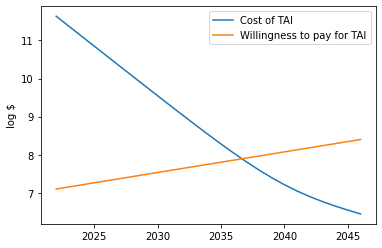

2047: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 27 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.9 log FLOP
-- Add 3.7 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.804
-- Assume FLOPs per param per sec of 1.2
-- 30.7 = 12.9 + 3.7 + -1.4 + 0 + 12 - 0.804 * 11.2 + 0.804 * (12.9 + 3.7 - 1.2)
-- 30.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.7 log FLOPs (~5 nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 5.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of 0.0001% of GDP. GDP grows a

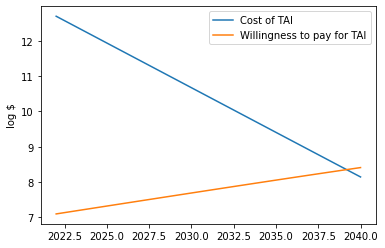

2041: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 28 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.6 log FLOP
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 5.1
-- Assume a scaling exponent of 1.043
-- Assume FLOPs per param per sec of 1.2
-- 43.0 = 16.6 + 2.5 + -0.3 + 5.1 + 12 - 1.043 * 11.2 + 1.043 * (16.6 + 2.5 - 1.2)
-- 43.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 43.0 log FLOPs (~9 billion decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.3x per year to a max of 0.00011% of GDP

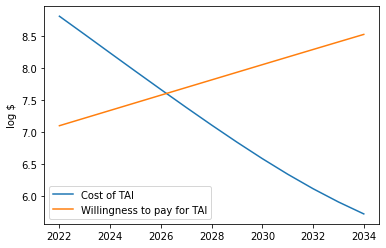

2035: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 31 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.7 log FLOP
-- Add 0.9 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 9.6
-- Assume a scaling exponent of 0.977
-- Assume FLOPs per param per sec of 1.3
-- 44.8 = 17.7 + 0.9 + -1.3 + 9.6 + 12 - 0.977 * 11.2 + 0.977 * (17.7 + 0.9 - 1.3)
-- 44.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 44.8 log FLOPs (~652 billion decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.5x per year to a max of 1e-05% of 

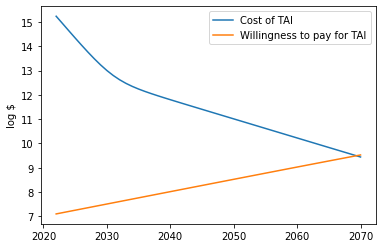

2071: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 34 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.8 log FLOP
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 7.4
-- Assume a scaling exponent of 1.119
-- Assume FLOPs per param per sec of 1.7
-- 32.8 = 11.8 + 1.7 + -0.8 + 7.4 + 12 - 1.119 * 11.2 + 1.119 * (11.8 + 1.7 - 1.7)
-- 32.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 32.8 log FLOPs (~604 nonillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.3x per year to a max of 0.00059% of GDP. GDP 

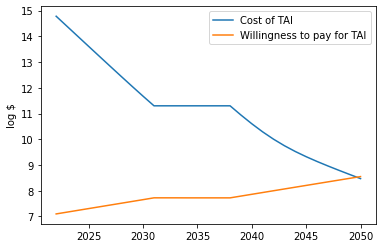

2051: ...Tool TAI made
2086: WAR!!! (US vs. Russia)
2091: War ends :)
...Boring future
-
-
-
-
############
## RUN 35 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.0 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.449
-- Assume FLOPs per param per sec of 1.7
-- 27.7 = 13.0 + 1.6 + -1.3 + 0 + 12 - 1.449 * 11.2 + 1.449 * (13.0 + 1.6 - 1.7)
-- 27.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 27.7 log FLOPs (~5 octillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.9x per year to a max of 0.00088% of GDP. GDP 

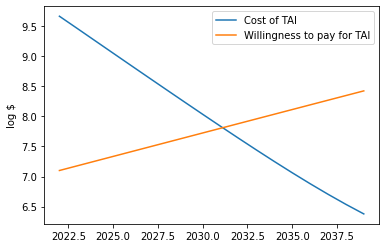

2040: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 36 ##
############
Anchor debug:
-- Assume human brain in inference takes 23.8 log FLOP
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 7.1
-- Assume a scaling exponent of 1.085
-- Assume FLOPs per param per sec of 1.4
-- 58.1 = 23.8 + 1.4 + -0.0 + 7.1 + 12 - 1.085 * 11.2 + 1.085 * (23.8 + 1.4 - 1.4)
-- 58.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 58.1 log FLOPs (~12 septillion decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.6x per year to a max of 0.0% of GDP. GDP grows at a rate of 

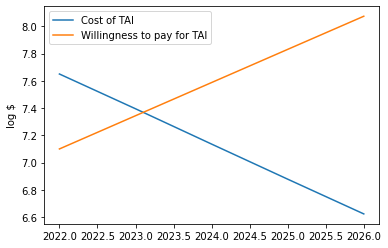

2027: ...Tool TAI made
2048: ...catastrophe from natural pathogen
2212: WAR!!! (US vs. Russia)
2221: War ends :)
...Boring future
-
-
-
-
############
## RUN 38 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.3 log FLOP
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 3.7
-- Assume a scaling exponent of 1.05
-- Assume FLOPs per param per sec of 1.1
-- 39.5 = 16.3 + 1.8 + -0.5 + 3.7 + 12 - 1.05 * 11.2 + 1.05 * (16.3 + 1.8 - 1.1)
-- 39.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 39.5 log FLOPs (~3 million decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increase

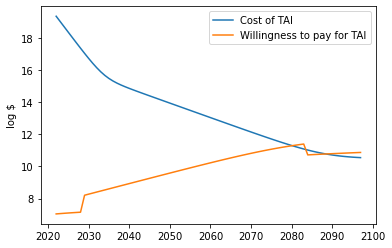

2098: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 40 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.9 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.234
-- Assume FLOPs per param per sec of 1.9
-- 37.0 = 16.9 + 1.6 + -0.2 + 0 + 12 - 1.234 * 11.2 + 1.234 * (16.9 + 1.6 - 1.9)
-- 37.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 37.0 log FLOPs (~10 thousand decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.4x per year to a max of 0.00431% of GDP. 

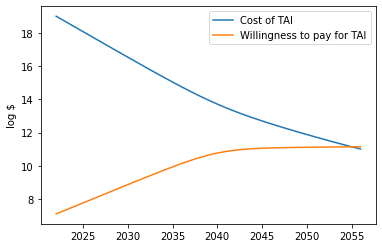

2057: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 41 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.7 log FLOP
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 5.1
-- Assume a scaling exponent of 0.919
-- Assume FLOPs per param per sec of 1.4
-- 33.9 = 13.7 + 1.0 + 0.2 + 5.1 + 12 - 0.919 * 11.2 + 0.919 * (13.7 + 1.0 - 1.4)
-- 33.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 33.9 log FLOPs (~8 decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.4x per year to a max of 0.0017% of GDP. GDP gr

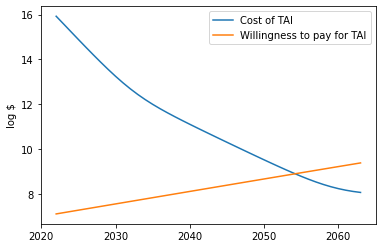

2064: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 42 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.9 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 2.1
-- Assume a scaling exponent of 0.73
-- Assume FLOPs per param per sec of 1.3
-- 32.1 = 13.9 + 1.6 + 0.3 + 2.1 + 12 - 0.73 * 11.2 + 0.73 * (13.9 + 1.6 - 1.3)
-- 32.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 32.1 log FLOPs (~135 nonillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.8x per year to a max of 3e-05% of GDP. GDP grows a

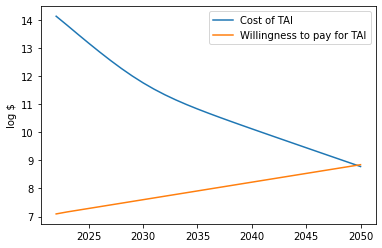

2051: ...Intentional misuse of TAI happened, was averted with catastrophe, and we abandon TAI
2057: War ends :)
2104: WAR!!! (US vs. Russia)
2107: War ends :)
2191: WAR!!! (US vs. China)
2198: ...catastrophe from nukes (war)
...Boring future
-
-
-
-
############
## RUN 43 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.3 log FLOP
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.193
-- Assume FLOPs per param per sec of 1.8
-- 25.9 = 12.3 + 1.9 + -1.7 + 0 + 12 - 1.193 * 11.2 + 1.193 * (12.3 + 1.9 - 1.8)
-- 25.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 25.9 log FLOPs (~87 septillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.7 years they get 2x cheaper, to a maximum of 24.0 log F

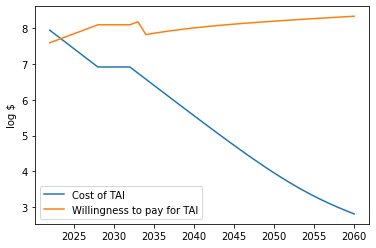

2061: ...Tool TAI made
2126: WAR!!! (Other)
2132: War ends :)
...Boring future
-
-
-
-
############
## RUN 44 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.5 log FLOP
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.501
-- Assume FLOPs per param per sec of 2.0
-- 32.7 = 15.5 + 1.1 + -1.0 + 0 + 12 - 1.501 * 11.2 + 1.501 * (15.5 + 1.1 - 2.0)
-- 32.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 32.7 log FLOPs (~480 nonillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.4x per year to a max of 0.0022% of GDP. GDP grows a

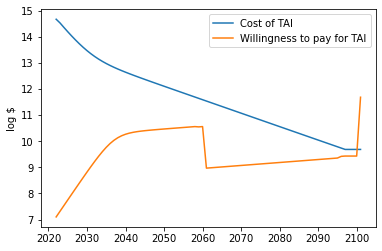

2102: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 45 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.0 log FLOP
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.612
-- Assume FLOPs per param per sec of 1.8
-- 34.3 = 17.0 + 2.4 + -1.1 + 0 + 12 - 0.612 * 11.2 + 0.612 * (17.0 + 2.4 - 1.8)
-- 34.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.3 log FLOPs (~19 decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.2x per year to a max of 2e-05% of GDP. GDP grow

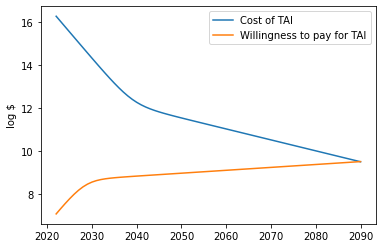

2091: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 46 ##
############
Anchor debug:
-- Assume human brain in inference takes 10.8 log FLOP
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 5.4
-- Assume a scaling exponent of 0.543
-- Assume FLOPs per param per sec of 1.7
-- 31.3 = 10.8 + 2.6 + 0.3 + 5.4 + 12 - 0.543 * 11.2 + 0.543 * (10.8 + 2.6 - 1.7)
-- 31.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 31.3 log FLOPs (~20 nonillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.4x per year to a max of 0.00068% of GDP. GDP gro

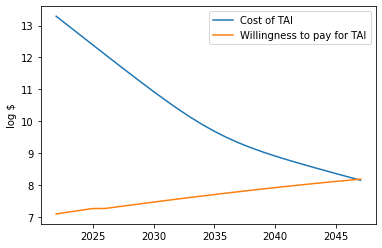

2048: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 47 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.6 log FLOP
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -1.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.818
-- Assume FLOPs per param per sec of 1.6
-- 36.0 = 17.6 + 2.4 + -1.9 + 0 + 12 - 0.818 * 11.2 + 0.818 * (17.6 + 2.4 - 1.6)
-- 36.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 36.0 log FLOPs (~1 thousand decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.2x per year to a max of 0.00327% of GDP. GDP grows at a rate of 1.023x per year

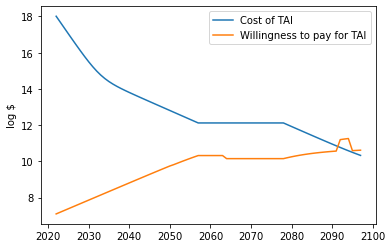

2098: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 48 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.3 log FLOP
-- Add 2.3 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 6.1
-- Assume a scaling exponent of 0.808
-- Assume FLOPs per param per sec of 1.2
-- 36.5 = 13.3 + 2.3 + 0.2 + 6.1 + 12 - 0.808 * 11.2 + 0.808 * (13.3 + 2.3 - 1.2)
-- 36.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 36.5 log FLOPs (~3 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.9x per year to a max of 0.0% of GDP. GDP

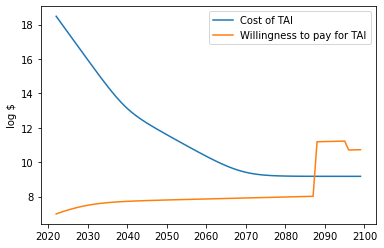

2100: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 49 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.2 log FLOP
-- Add 2.9 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 0.8
-- Assume a scaling exponent of 0.79
-- Assume FLOPs per param per sec of 1.2
-- 35.3 = 15.2 + 2.9 + -0.1 + 0.8 + 12 - 0.79 * 11.2 + 0.79 * (15.2 + 2.9 - 1.2)
-- 35.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 35.3 log FLOPs (~180 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.5x per year to a max of 0.00087% of GDP. GDP grows at a rate of 1.019x per year.
If a

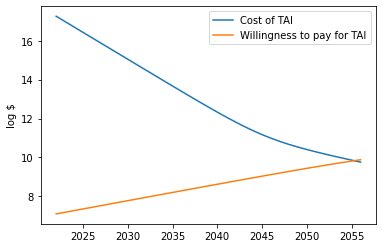

2057: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 50 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.4 log FLOP
-- Add 4.2 log FLOP for efficiency
-- Assume a transformative model takes 1.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.287
-- Assume FLOPs per param per sec of 0.9
-- 33.7 = 11.4 + 4.2 + 1.7 + 0 + 12 - 1.287 * 11.2 + 1.287 * (11.4 + 4.2 - 0.9)
-- 33.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 33.7 log FLOPs (~5 decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.8x per year to a max of 0.00099% of GDP. GDP grows at

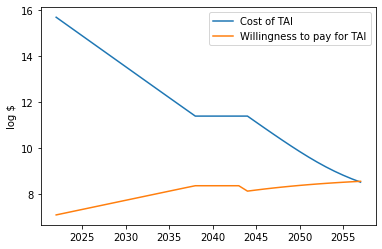

2058: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-


In [17]:
for i in range(50):
    print('-')
    print('-')
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbose=True)

In [18]:
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            raw=True, verbose=True, n=RUNS)

Checking cache...
Generating Bayes net...


100%|█████████████████████████████████████████████████████████| 100000/100000 [35:01<00:00, 47.58it/s]


...Generated
Caching...
...Cached


In [19]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

0. World State At Year
## 2030 ##
[('boring', 96.982),
 ('xrisk_full_unaligned_tai_singleton', 1.062),
 ('aligned_tai', 0.78),
 ('xrisk_full_unaligned_tai_extinction', 0.734),
 ('xrisk_subtly_unaligned_tai', 0.19),
 ('xrisk_tai_misuse', 0.18),
 ('xrisk_nukes_war', 0.042),
 ('xrisk_nukes_accident', 0.019),
 ('xrisk_unknown_unknown', 0.006),
 ('xrisk_bio_accident', 0.005),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 74.829),
 ('aligned_tai', 13.884),
 ('xrisk_full_unaligned_tai_singleton', 4.463),
 ('xrisk_full_unaligned_tai_extinction', 3.029),
 ('xrisk_subtly_unaligned_tai', 2.43),
 ('xrisk_tai_misuse', 1.082),
 ('xrisk_nukes_war', 0.164),
 ('xrisk_nukes_accident', 0.07),
 ('xrisk_unknown_unknown', 0.023),
 ('xrisk_bio_accident', 0.019),
 ('xrisk_nanotech', 0.006),
 ('xrisk_bio_nonstate', 0.001),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 58.398),
 ('alig

In [20]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0B. Catastrophe States At Year
## 2023 ##
[('', 99.5), ('engineered_pathogen', 0.12), ('nukes_war', 0.12)]
-
-
## 2030 ##
[('', 95.93),
 ('nukes_war', 0.86),
 ('xrisk_full_unaligned_tai_singleton', 0.86),
 ('xrisk_full_unaligned_tai_extinction', 0.73),
 ('engineered_pathogen', 0.56),
 ('natural_pathogen', 0.4),
 ('nukes_accident', 0.33),
 ('xrisk_tai_misuse', 0.15),
 ('averting_misaligned_tai', 0.12)]
-
-
## 2050 ##
[('', 85.48),
 ('xrisk_full_unaligned_tai_singleton', 3.54),
 ('xrisk_full_unaligned_tai_extinction', 2.97),
 ('nukes_war', 2.42),
 ('engineered_pathogen', 1.49),
 ('natural_pathogen', 1.08),
 ('nukes_accident', 1.05),
 ('xrisk_tai_misuse', 0.86),
 ('averting_misaligned_tai', 0.51)]
-
-
## 2070 ##
[('', 80.87),
 ('xrisk_full_unaligned_tai_singleton', 4.47),
 ('xrisk_full_unaligned_tai_extinction', 3.76),
 ('nukes_war', 3.05),
 ('engineered_pathogen', 2.06),
 ('natural_pathogen', 1.43),
 ('nukes_accident', 1.35),
 ('xrisk_tai_misuse', 1.17),
 ('averting_misaligned_tai', 0.63

In [21]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0C. *First* Catastrophe State At Year
## 2023 ##
[('', 99.5), ('engineered_pathogen', 0.12), ('nukes_war', 0.12)]
-
-
## 2030 ##
[('', 95.93),
 ('nukes_war', 0.89),
 ('xrisk_full_unaligned_tai_singleton', 0.86),
 ('xrisk_full_unaligned_tai_extinction', 0.73),
 ('engineered_pathogen', 0.56),
 ('natural_pathogen', 0.4),
 ('nukes_accident', 0.34),
 ('xrisk_tai_misuse', 0.15),
 ('averting_misaligned_tai', 0.12)]
-
-
## 2050 ##
[('', 85.48),
 ('xrisk_full_unaligned_tai_singleton', 3.54),
 ('xrisk_full_unaligned_tai_extinction', 2.97),
 ('nukes_war', 2.65),
 ('engineered_pathogen', 1.59),
 ('natural_pathogen', 1.17),
 ('nukes_accident', 1.13),
 ('xrisk_tai_misuse', 0.86),
 ('averting_misaligned_tai', 0.53)]
-
-
## 2070 ##
[('', 80.87),
 ('xrisk_full_unaligned_tai_singleton', 4.47),
 ('xrisk_full_unaligned_tai_extinction', 3.76),
 ('nukes_war', 3.5),
 ('engineered_pathogen', 2.28),
 ('natural_pathogen', 1.62),
 ('nukes_accident', 1.54),
 ('xrisk_tai_misuse', 1.17),
 ('averting_misaligned_tai'

In [22]:
print('0D. Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

0D. Double Catastrophe X-Risks
## 2030 ##
[('', 99.996),
 ('engineered_pathogen->natural_pathogen', 0.001),
 ('nukes_war->engineered_pathogen', 0.001),
 ('nukes_war->nukes_war', 0.001),
 ('nukes_accident->nukes_war', 0.001)]
-
-
## 2050 ##
[('', 99.968),
 ('nukes_war->engineered_pathogen', 0.007),
 ('nukes_war->nukes_war', 0.005),
 ('nukes_war->nukes_accident', 0.003),
 ('natural_pathogen->nukes_war', 0.003),
 ('nukes_accident->nukes_accident', 0.002),
 ('natural_pathogen->natural_pathogen', 0.002),
 ('engineered_pathogen->nukes_war', 0.002),
 ('engineered_pathogen->natural_pathogen', 0.002),
 ('nukes_accident->nukes_war', 0.002),
 ('averting_misaligned_tai->engineered_pathogen', 0.001),
 ('engineered_pathogen->nukes_accident', 0.001),
 ('natural_pathogen->engineered_pathogen', 0.001),
 ('averting_misaligned_tai->nukes_war', 0.001)]
-
-
## 2070 ##
[('', 99.957),
 ('nukes_war->engineered_pathogen', 0.008),
 ('nukes_war->nukes_war', 0.007),
 ('engineered_pathogen->nukes_war', 0.004),
 ('

In [23]:
print('0E. # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

0E. # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [24]:
print('0F. War States At Year')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 2)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

0F. War States At Year
## 2030 ##
[('', 73.49),
 ('US/China', 18.72),
 ('US/Russia', 7.02),
 ('Other', 0.73),
 ('US/China US/Russia', 0.02),
 ('US/China US/China', 0.01),
 ('US/Russia US/Russia', 0.0)]
-
-
## 2050 ##
[('', 50.83),
 ('US/China', 34.25),
 ('US/Russia', 10.76),
 ('Other', 3.21),
 ('US/China US/China', 0.34),
 ('US/China US/Russia', 0.3),
 ('Other US/China', 0.16),
 ('Other US/Russia', 0.07),
 ('US/Russia US/Russia', 0.06),
 ('Other Other', 0.01),
 ('US/China US/China US/Russia', 0.0),
 ('Other US/China US/China', 0.0),
 ('US/China US/Russia US/Russia', 0.0),
 ('Other US/China US/Russia', 0.0),
 ('US/Russia US/Russia US/Russia', 0.0)]
-
-
## 2070 ##
[('', 43.34),
 ('US/China', 35.12),
 ('US/Russia', 12.33),
 ('Other', 5.73),
 ('US/China US/Russia', 1.04),
 ('US/China US/China', 0.96),
 ('Other US/China', 0.86),
 ('Other US/Russia', 0.32),
 ('US/Russia US/Russia', 0.21),
 ('Other Other', 0.05),
 ('US/China US/China US/Russia', 0.01),
 ('Other US/China US/Russia', 0.01),
 ('

In [25]:
print('0G. War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

0G. War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 25.0,
 90: 50.0,
 95: 75.0,
 99: 100.0}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 14.3,
 70: 25.0,
 80: 39.3,
 90: 60.7,
 95: 75.0,
 99: 92.9}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 6.2,
 60: 12.5,
 70: 18.8,
 80: 29.2,
 90: 47.9,
 95: 66.7,
 99: 91.7}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 2.6,
 50: 6.4,
 60: 10.3,
 70: 15.4,
 80: 23.1,
 90: 35.9,
 95: 50.0,
 99: 83.3}
-
-
## Percent of time in war as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.6,
 40: 2.8,
 50: 5.1,
 60: 7.9,
 70: 11.2,
 80: 15.7,
 90: 23.6,
 95: 32.0,
 99: 53.4}
-
-


In [26]:
print('0H. # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')

0H. # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 2.0,
 90: 2.0,
 95: 3.0,
 99: 3.0}
-
-


In [27]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['engineered_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.73%
2050 - 5.13%
2100 - 10.09%


In [28]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['natural_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.36%
2050 - 3.84%
2100 - 6.88%


In [29]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'pathogen' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


2B. Pathogen Catastrophic Risk (10%+ death)
2030 - 0.98%
2050 - 2.84%
2100 - 5.44%


In [30]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk_bio' in e['collectors'][y_c]['category'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    

2C. Pathogen Extinction Risk
2030 - 0.005%
2050 - 0.02%
2100 - 0.033%


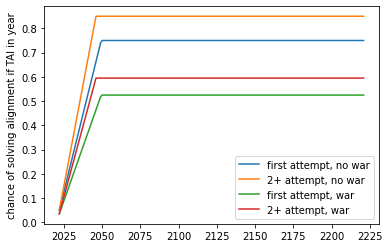

In [31]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [32]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with no war 5.0% (2nd attempt 5.0%)
Year: 2023 - chance of solving TAI alignment with no war 8.0% (2nd attempt 8.0%)
Year: 2024 - chance of solving TAI alignment with no war 10.0% (2nd attempt 12.0%)
Year: 2025 - chance of solving TAI alignment with no war 13.0% (2nd attempt 15.0%)
Year: 2026 - chance of solving TAI alignment with no war 15.0% (2nd attempt 18.0%)
Year: 2027 - chance of solving TAI alignment with no war 18.0% (2nd attempt 22.0%)
Year: 2028 - chance of solving TAI alignment with no war 20.0% (2nd attempt 25.0%)
Year: 2029 - chance of solving TAI alignment with no war 23.0% (2nd attempt 28.0%)
Year: 2030 - chance of solving TAI alignment with no war 25.0% (2nd attempt 32.0%)
Year: 2031 - chance of solving TAI alignment with no war 28.0% (2nd attempt 35.0%)
Year: 2032 - chance of solving TAI alignment with no war 31.0% (2nd attempt 38.0%)
Year: 2033 - chance of solving TAI alignment with no war 33.0% (2nd attempt 42.0%)
Year: 20

In [33]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))


Year: 2022 - chance of solving TAI alignment with war 3.0% (2nd attempt 3.0%)
Year: 2023 - chance of solving TAI alignment with war 5.0% (2nd attempt 6.0%)
Year: 2024 - chance of solving TAI alignment with war 7.0% (2nd attempt 8.0%)
Year: 2025 - chance of solving TAI alignment with war 9.0% (2nd attempt 11.0%)
Year: 2026 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%)
Year: 2027 - chance of solving TAI alignment with war 12.0% (2nd attempt 15.0%)
Year: 2028 - chance of solving TAI alignment with war 14.0% (2nd attempt 18.0%)
Year: 2029 - chance of solving TAI alignment with war 16.0% (2nd attempt 20.0%)
Year: 2030 - chance of solving TAI alignment with war 18.0% (2nd attempt 22.0%)
Year: 2031 - chance of solving TAI alignment with war 20.0% (2nd attempt 24.0%)
Year: 2032 - chance of solving TAI alignment with war 21.0% (2nd attempt 27.0%)
Year: 2033 - chance of solving TAI alignment with war 23.0% (2nd attempt 29.0%)
Year: 2034 - chance of solving TAI alignment wi

In [34]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'tai' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

3. AI Catastrophic Risk* (10%+ death)
2030 - 1.88%
2050 - 8.09%
2100 - 12.24%


In [35]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_full_unaligned_tai_extinction',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


4. AI Extinction Risk*
2030 - 0.73%
2050 - 3.03%
2100 - 4.52%


In [36]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4B. AI X-Risk
2024 - 0.2% (Extinction: 0.1%, Bad TAI singleton: 0.1%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2030 - 2.2% (Extinction: 0.7%, Bad TAI singleton: 1.1%, Subtly misaligned singleton: 0.2%, Misuse singleton: 0.2%)
2050 - 11.0% (Extinction: 3.0%, Bad TAI singleton: 4.5%, Subtly misaligned singleton: 2.4%, Misuse singleton: 1.1%)
2070 - 15.5% (Extinction: 3.9%, Bad TAI singleton: 5.7%, Subtly misaligned singleton: 4.4%, Misuse singleton: 1.5%)
2100 - 18.8% (Extinction: 4.5%, Bad TAI singleton: 6.7%, Subtly misaligned singleton: 5.8%, Misuse singleton: 1.8%)
2200 - 21.4% (Extinction: 5.1%, Bad TAI singleton: 7.4%, Subtly misaligned singleton: 6.7%, Misuse singleton: 2.2%)


In [37]:
# “P(misalignment x-risk|AGI)”: Conditional on AGI being developed by 2070, humanity will go extinct or
# drastically curtail its future potential due to loss of control of AGI

print('4C. AI X-Risk conditional on AGI by 2070')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          conditional_on=lambda e: e['final_state']['tai_year'] <= 2070 if e['final_state']['tai_year'] is not None else False,
                          n=RUNS)

for y_c in [2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4C. AI X-Risk conditional on AGI by 2070
2070 - 32.3% (Extinction: 8.1%, Bad TAI singleton: 11.9%, Subtly misaligned singleton: 9.2%, Misuse singleton: 3.1%)
2100 - 32.6% (Extinction: 8.1%, Bad TAI singleton: 12.0%, Subtly misaligned singleton: 9.3%, Misuse singleton: 3.1%)


In [38]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

4D. Aligned TAI
2024 - 0.03%
2030 - 0.78%
2050 - 13.88%
2070 - 25.64%
2100 - 34.2%
2200 - 40.0%


In [39]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
pprint(sq.get_percentiles([2223 if yr is None else yr for yr in yrs]))
print('-')

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    if hi is None:
        r = bayes.bayesnet(define_event,
                           find=lambda e: e['final_state']['tai_year'] is None or e['final_state']['tai_year'] >= low,
                           n=RUNS)
    else:
        r = bayes.bayesnet(define_event,
                           find=lambda e: (e['final_state']['tai_year'] is not None and
                                          (e['final_state']['tai_year'] >= low and e['final_state']['tai_year'] <= hi)),
                           n=RUNS)
    return round(r * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2149: {}%'.format(bin_tai_yrs(2100, 2149)))
print('2149-2199: {}%'.format(bin_tai_yrs(2149, 2199)))
print('>2200: {}%'.format(bin_tai_yrs(low=2220)))
print('-')

print('By EOY 2023: {}%'.format(bin_tai_yrs(hi=2023)))
print('By EOY 2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('By EOY 2025: {}%'.format(bin_tai_yrs(hi=2025)))
print('By EOY 2030: {}% (Ajeya 2022: 15%)'.format(bin_tai_yrs(hi=2030)))
print('By EOY 2032: {}% (within 10yrs)'.format(bin_tai_yrs(hi=2032)))
print('By EOY 2036: {}% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)'.format(bin_tai_yrs(hi=2036)))
print('By EOY 2040: {}% (Ajeya 2022: 50%)'.format(bin_tai_yrs(hi=2040)))
print('By EOY 2042: {}% (FTX: 20%, 10%-45%)'.format(bin_tai_yrs(hi=2042)))
print('By EOY 2047: {}% (within 25yrs)'.format(bin_tai_yrs(hi=2047)))
print('By EOY 2050: {}% (Ajeya 2020: 50%, Ajeya 2022: 60%)'.format(bin_tai_yrs(hi=2050)))
print('By EOY 2060: {}% (Holden benchmark - 25%-75%, Holden: 50%)'.format(bin_tai_yrs(hi=2060)))
print('By EOY 2070: {}% (Carlsmith: 50%)'.format(bin_tai_yrs(hi=2070)))
print('By EOY 2072: {}% (within 50yrs)'.format(bin_tai_yrs(hi=2072)))
print('By EOY 2078: {}% (within my expected lifetime)'.format(bin_tai_yrs(hi=2078)))
print('By EOY 2099: {}% (FTX: 60%, >30%)'.format(bin_tai_yrs(hi=2099)))
print('By EOY 2100: {}% (Holden benchmark - 33%-90%, Holden: 66%)'.format(bin_tai_yrs(hi=2100)))
print('By EOY 2122: {}% (within 100yrs)'.format(bin_tai_yrs(hi=2122)))
print('By EOY 2222: {}% (within 200yrs)'.format(bin_tai_yrs(hi=2222)))


4E. When TAI?
-
{1: 2026.0,
 5: 2031.0,
 10: 2036.0,
 20: 2043.0,
 30: 2050.0,
 40: 2060.0,
 50: 2073.0,
 60: 2096.0,
 70: 2191.0,
 80: 2223.0,
 90: 2223.0,
 95: 2223.0,
 99: 2223.0}
-
<2024: 0.4%
2025-2029: 3.2%
2030-2039: 11.6%
2040-2049: 13.7%
2050-2059: 10.3%
2060-2069: 8.2%
2070-2079: 6.1%
2080-2089: 4.2%
2090-2099: 3.1%
2100-2149: 6.4%
2149-2199: 3.2%
>2200: 28.5%
-
By EOY 2023: 0.2%
By EOY 2024: 0.4%
By EOY 2025: 0.8%
By EOY 2030: 4.5% (Ajeya 2022: 15%)
By EOY 2032: 6.3% (within 10yrs)
By EOY 2036: 11.0% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)
By EOY 2040: 16.7% (Ajeya 2022: 50%)
By EOY 2042: 19.6% (FTX: 20%, 10%-45%)
By EOY 2047: 26.5% (within 25yrs)
By EOY 2050: 30.1% (Ajeya 2020: 50%, Ajeya 2022: 60%)
By EOY 2060: 40.2% (Holden benchmark - 25%-75%, Holden: 50%)
By EOY 2070: 48.2% (Carlsmith: 50%)
By EOY 2072: 49.5% (within 50yrs)
By EOY 2078: 53.1% (within my expected lifetime)
By EOY 2099: 60.9% (FTX: 60%, >30%)
By EOY 2100: 61.2% (Holden benchmark - 33%-9

In [40]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'nukes' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 1.24%
2050 - 3.87%
2100 - 6.46%


In [41]:
print('6. Nuclear Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    war = find(y_c, 'xrisk_nukes_war')
    accident = find(y_c, 'xrisk_nukes_accident')
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) * 100, 3),
                                                      round(war * 100, 3),
                                                      round(accident * 100, 3)))
    

6. Nuclear Extinction Risk*
2030 - 0.061% (war: 0.042%, accident: 0.019%)
2050 - 0.234% (war: 0.164%, accident: 0.07%)
2100 - 0.413% (war: 0.28%, accident: 0.133%)
2200 - 0.626% (war: 0.435%, accident: 0.191%)


In [42]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'supervolcano' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    
# NOTE: All other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.002%
2050 - 0.006%
2100 - 0.012%


In [43]:
print('8. Non-Anthropogenic Extinction Risk*')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_supervolcano',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 4)))

# NOTE: All other sources < 0.01%


8. Non-Anthropogenic Extinction Risk*
2030 - 0.0%
2050 - 0.0%
2100 - 0.001%


In [44]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 4.08%
2050 - 14.52%
2100 - 22.97%


In [45]:
print('10. Total Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

10. Total Extinction Risk*
2030 - 0.81% (AI: 0.73%, Nukes: 0.061% (War: 0.042% Accident: 0.019%), Bio: 0.005% (War: 0.0%, Accident: 0.005%, Nonstate: 0.0%), Nano: 0.0%, Natural: 0.0%, Other: 0.006%)
2050 - 3.31% (AI: 3.03%, Nukes: 0.234% (War: 0.164% Accident: 0.07%), Bio: 0.02% (War: 0.0%, Accident: 0.019%, Nonstate: 0.001%), Nano: 0.006%, Natural: 0.0%, Other: 0.023%)
2100 - 5.07% (AI: 4.52%, Nukes: 0.413% (War: 0.28% Accident: 0.133%), Bio: 0.033% (War: 0.0%, Accident: 0.032%, Nonstate: 0.001%), Nano: 0.022%, Natural: 0.001%, Other: 0.081%)
2200 - 6.19% (AI: 5.06%, Nukes: 0.626% (War: 0.435% Accident: 0.191%), Bio: 0.054% (War: 0.0%, Accident: 0.049%, Nonstate: 0.005%), Nano: 0.214%, Natural: 0.002%, Other: 0.233%)


In [46]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2035, 2037, 2040, 2045, 2050, 2060, 2070, 2100, 2200]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2023 - 0.14% (AI: 0.14%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.001%)
2024 - 0.19% (AI: 0.18%, Nukes: 0.008%, Bio: 0.002%, Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2030 - 2.24% (AI: 2.17%, Nukes: 0.061%, Bio: 0.005%, Nano: 0.0%, Natural: 0.0%, Other: 0.006%)
2035 - 4.67% (AI: 4.54%, Nukes: 0.12%, Bio: 0.007%, Nano: 0.0%, Natural: 0.0%, Other: 0.008%)
2037 - 5.76% (AI: 5.59%, Nukes: 0.14%, Bio: 0.012%, Nano: 0.0%, Natural: 0.0%, Other: 0.014%)
2040 - 7.38% (AI: 7.18%, Nukes: 0.165%, Bio: 0.014%, Nano: 0.0%, Natural: 0.0%, Other: 0.016%)
2045 - 9.64% (AI: 9.4%, Nukes: 0.202%, Bio: 0.018%, Nano: 0.004%, Natural: 0.0%, Other: 0.02%)
2050 - 11.29% (AI: 11.0%, Nukes: 0.234%, Bio: 0.02%, Nano: 0.006%, Natural: 0.0%, Other: 0.023%)
2060 - 13.9% (AI: 13.55%, Nukes: 0.282%, Bio: 0.022%, Nano: 0.008%, Natural: 0.0%, Other: 0.032%)
2070 - 15.96% (AI: 15.55%, Nukes: 0.

In [47]:
print('10C. Total X-Risk OR catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10C. Total X-Risk OR catastrophe
2024 - 0.82%
2030 - 4.55%
2050 - 18.16%
2070 - 24.96%
2100 - 30.28%
2200 - 38.15%


In [48]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10D. Total X-Risk AND catastrophe
2024 - 0.15%
2030 - 1.76%
2050 - 7.65%
2070 - 10.13%
2100 - 12.07%
2200 - 14.18%


In [49]:
print('11. Year of Extinction*')
rs = bayes.bayesnet(define_event,
                    find=lambda e: (e['final_state']['category'], e['final_state']['final_year']),
                    raw=True,
                    n=RUNS)
extinction_years = [r[1] if r[0] in extinctions else 100000 for r in rs]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


11. Year of Extinction*
{5: 2097.0, 25: 100000.0, 50: 100000.0, 75: 100000.0, 95: 100000.0}


In [50]:
print('12. Future Human Births*')
pop_per_year = sq.lognorm(100*M, 1*B)
populations = [round((y - CURRENT_YEAR) * sq.sample(pop_per_year), 0) for y in extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


12. Future Human Births*


{5: '10^10.4', 25: '10^13.2', 50: '10^13.5', 75: '10^13.7', 95: '10^14.0'}

In [51]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(36000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 2*B)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.1

p_aligned_tai_by_2024 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2024]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2024 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2024]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2024


def sim_2024():
    n = sq.sample(n_in_trials_2024)
    if sq.event_occurs(p_aligned_tai_by_2024):
        return n
    elif sq.event_occurs(p_xrisk_by_2024):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2024):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_aligned_tai_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2030 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2030

def sim_2030(): # TODO: DRY
    n = sq.sample(n_in_trials_2030)
    if sq.event_occurs(p_aligned_tai_by_2030):
        return n
    elif sq.event_occurs(p_xrisk_by_2030):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2030):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 35624, 25: 49236, 50: 61827, 75: 79349, 95: 123553}
## 2030 ##
{5: 99547, 25: 154628, 50: 205839, 75: 281022, 95: 67150540}


In [52]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

31. Nuclear Weapon Use
2024 - 4.43%
2030 - 9.71%


In [53]:
print('53. GWP >15% by 2100?')
bayes.bayesnet(define_event,
               find=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                              (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               n=RUNS) * 0.7 * 0.9


53. GWP >15% by 2100?


0.21542849999999997

In [54]:
print('53. Year GWP >15% if by 2100')
bayes.bayesnet(define_event,
               find=lambda e: e['final_state']['final_year'],
               conditional_on=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                         (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               reduce_fn=lambda y: sq.get_percentiles(y, [95, 75, 50, 25, 5]),
               n=RUNS)


53. Year GWP >15% if by 2100


{95: 2092.0, 75: 2071.0, 50: 2055.0, 25: 2044.0, 5: 2034.0}

In [55]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    p_aligned_tai = bayes.bayesnet(define_event,
                                   find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                                   n=RUNS)
    p_boring = bayes.bayesnet(define_event,
                              find=lambda e: e['collectors'][y_c]['category'] == 'boring',
                              n=RUNS)
    
    print('{} - {} * {} + {} * {} = {}%'.format(y_c,
                                                round(p_boring, 3),
                                                round(p_space_colony_if_boring(y_c - CURRENT_YEAR), 3),
                                                round(p_aligned_tai, 3),
                                                p_space_colony_if_aligned_tai,
                                                round(((p_boring * p_space_colony_if_boring(y_c - CURRENT_YEAR)) +
                                                       (p_aligned_tai * p_space_colony_if_aligned_tai)) * 100, 2)))


55. Space Colony*
2030 - 0.97 * 0.016 + 0.008 * 0.1 = 1.62%
2050 - 0.748 * 0.055 + 0.139 * 0.1 = 5.47%
2100 - 0.464 * 0.145 + 0.342 * 0.1 = 10.13%
